```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

## Linear Coriolis term

The coriolis parameter is modeled as a linear function
$$f = \tilde{f}Â + \beta y$$
where $y=0$ currently represent the lower boundary of the first non-ghost-cell of the domain.

#### Import modules and set up environment

In [137]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import os
import pyopencl
import datetime
import sys

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [138]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce GTX 780


In [139]:
#Create output directory for images
imgdir='images_linearCoriolis_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print "Saving images to " + imgdir

Saving images to images_linearCoriolis_2018_01_16-14_44_29


## Parameters

Let's try to define the parameters that we need in order to create our exciting bottom topography.

domain width:   (3930374.7664807565, 200000.0, 500000.0)
domain width:   4630374.76648
domain height:  4000000.0
adjusted domain width:  2500000.0
domain_size:  (400, 500)
1900000.0
(400, 500)
1000.0 100.005


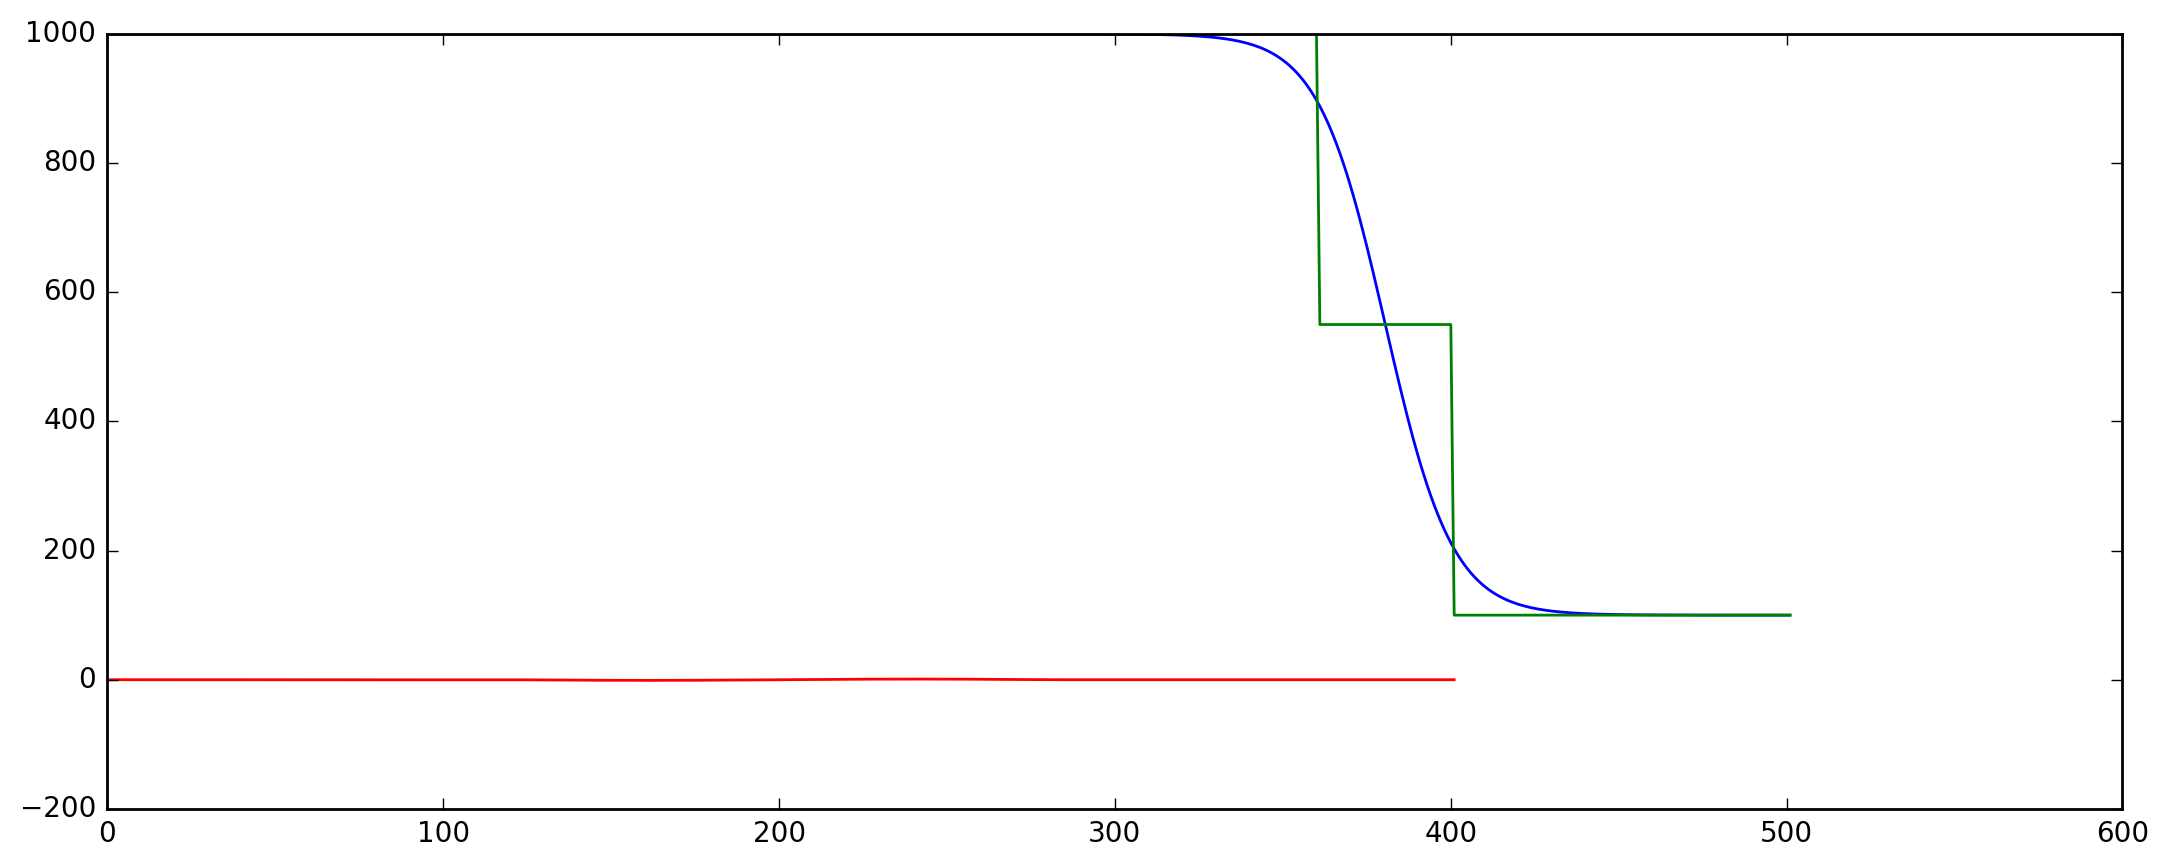

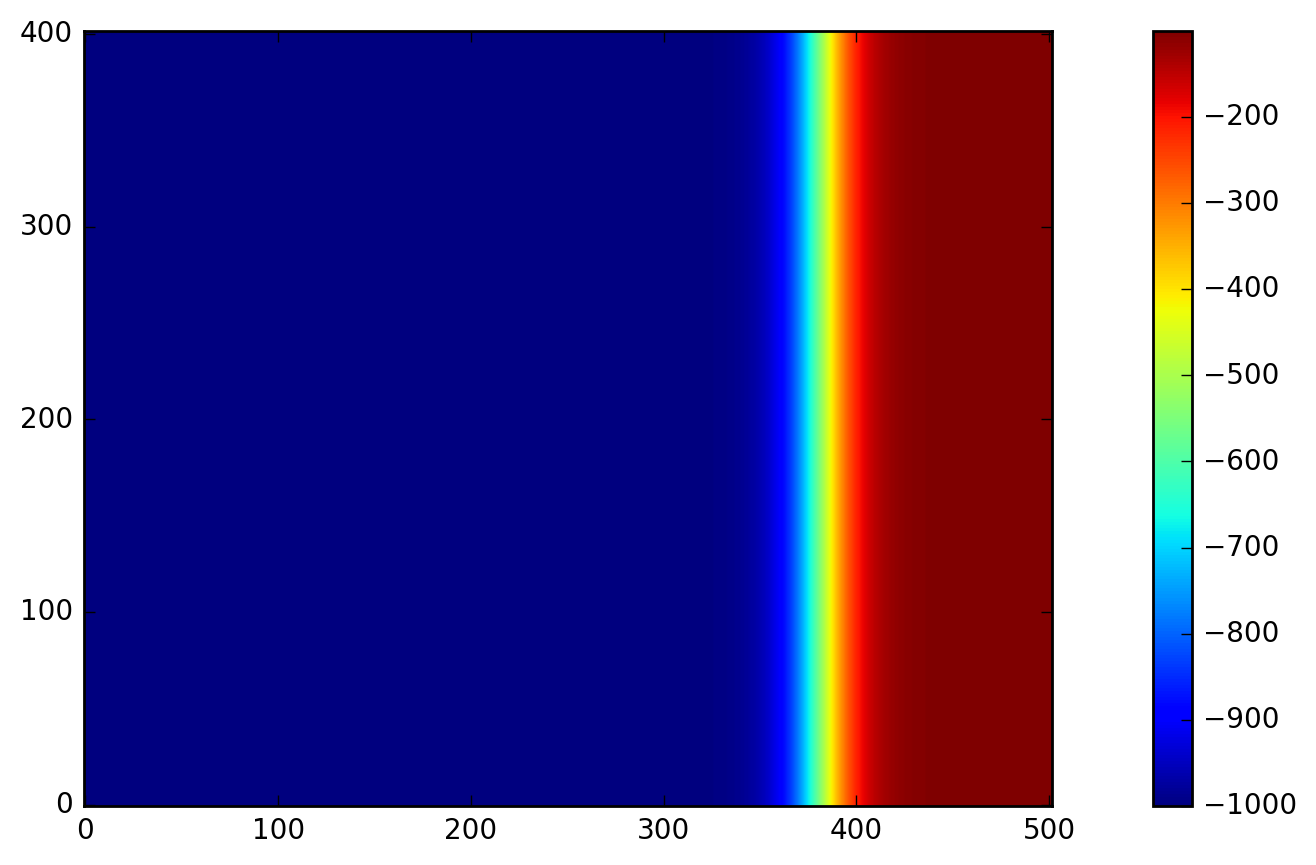

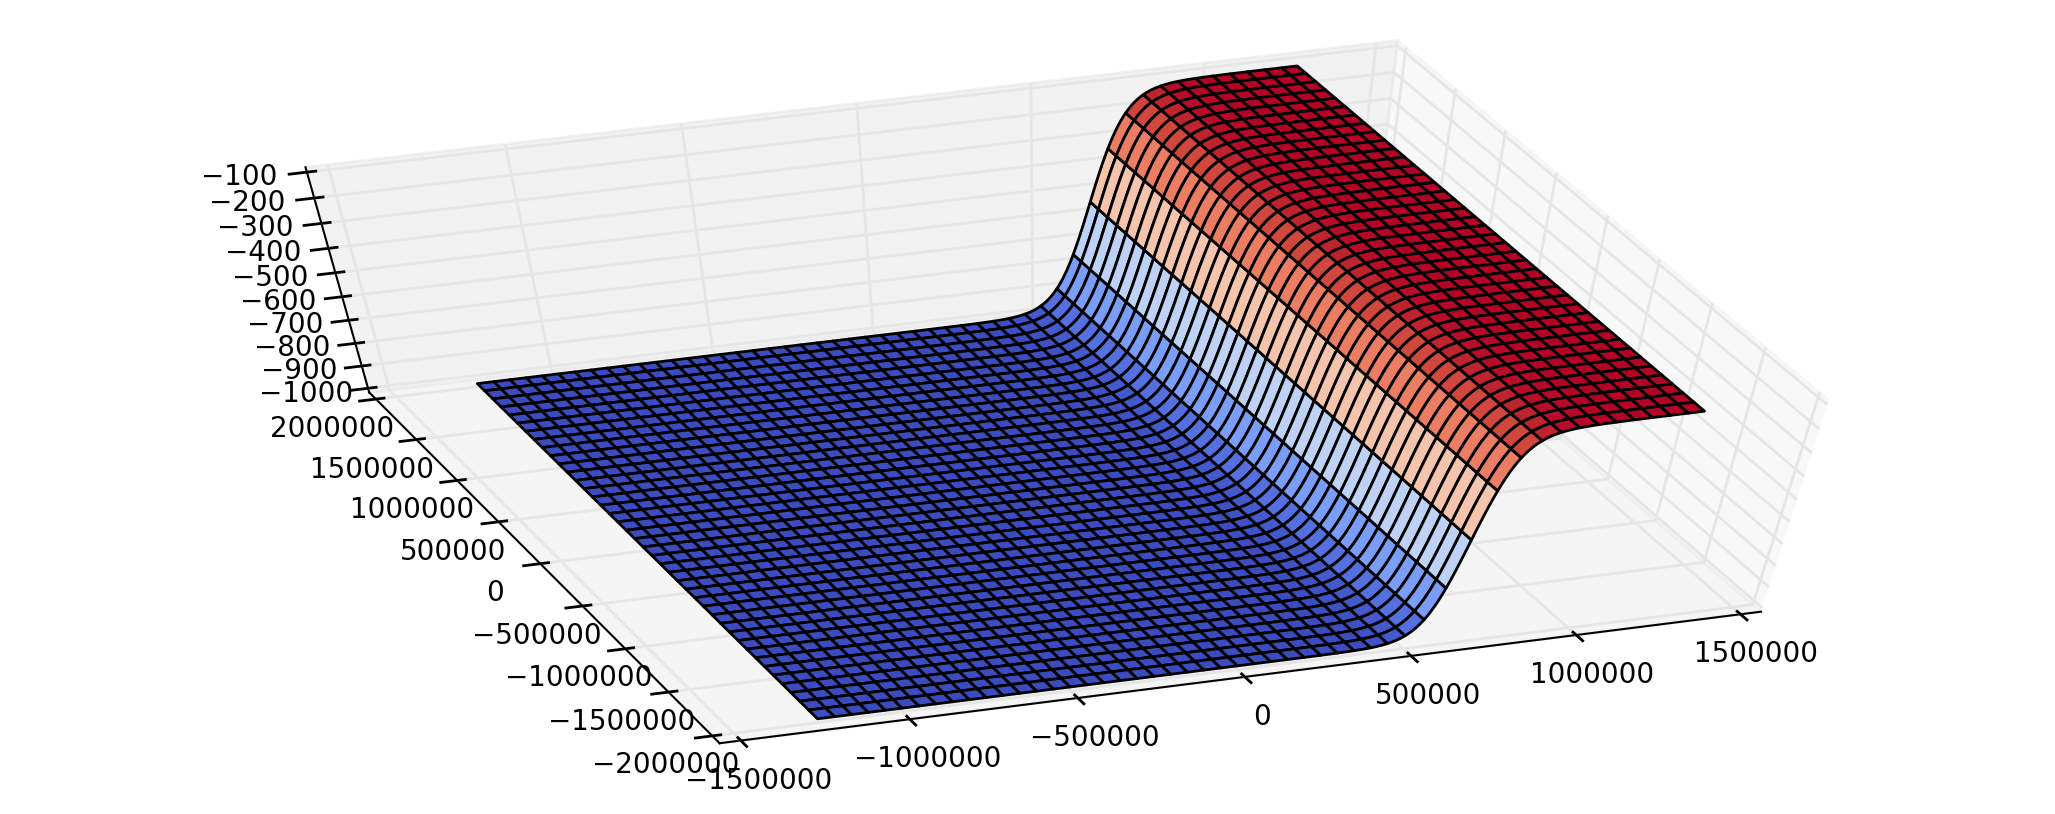

In [146]:
# Global parameters:
g = 9.81 # m/s^2
r = 0.0
A = 0 # Eddy viscocity parameter


# Coriolis parameter at 60 degrees north
# f = 4.4e-5 # source: http://www.shodor.org/os411/courses/_master/tools/calculators/coriolis/index.html
f = 1.26e-4 # source: https://www.mt-oceanography.info/Utilities/coriolis.html
beta = 0.0

# water depths:
shelf_depth = 100        # m
deep_water_depth = 1000  # m

# Domain size: 
domain_height = 4000*1e3 # length of Norway
continental_shelf_width = 500*1e3 # km ?
shelf_drop_width = 200*1e3 # ? 
c0 = np.sqrt(g*deep_water_depth)
deep_water_width = 5*c0 / f


print "domain width:  ", (deep_water_width, shelf_drop_width, continental_shelf_width)
print "domain width:  ", deep_water_width + shelf_drop_width + continental_shelf_width
print "domain height: ", domain_height

# Change domain width to a nice round number:
total_domain_width = 2500e3 # based on above value 4630374.76648 m
deep_water_width = total_domain_width - continental_shelf_width - shelf_drop_width 
print "adjusted domain width: ", total_domain_width

# Choose some appropriate grid sizes
dx = 5000
dy = 10000

nx = int(total_domain_width/dx)
ny = int(domain_height / dy)

print "domain_size: ", (ny, nx)


ghosts = [1,1,1,1]
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])
h0 = np.ones(dataShape, dtype=np.float32, order='C');

for j in range(20):
    for i in range(nx):
        h0[j,i] = i+j
        
#fig = plt.figure(figsize=(13,5))
#plt.imshow(h0, origin='lower')
#plt.colorbar()

# Making the correct tanh in x-direction
shelf_x0 = total_domain_width - continental_shelf_width - shelf_drop_width/2
print shelf_x0
tanh_lambda = 1.0/(shelf_drop_width/2)
fig = plt.figure(figsize=(13,5))
for i in range(dataShape[1]):
    x = (i+0.5-ghosts[3])*dx
    h0[0,i] = deep_water_depth + (shelf_depth - deep_water_depth)*(np.tanh(tanh_lambda*(x - shelf_x0))+1)/2
    h0[1,i] = deep_water_depth
    if (x > deep_water_width):
        h0[1,i] = 0.5*(shelf_depth + deep_water_depth)
    if (x > deep_water_width + shelf_drop_width):
        h0[1,i] = shelf_depth 
plt.plot(h0[0,:])
plt.plot(h0[1,:])


sine_center = dy*ny/2.0
sine_period = dy*ny*0.4
sine_amplitude = continental_shelf_width/2.0


for j in range(dataShape[0]):
    y = (j+0.5-ghosts[2])*dy
    h0[j,0] = 0
    if (y > sine_center - sine_period/2 and y < sine_center + sine_period/2):
        h0[j,0] = np.sin((y-sine_center)*2*np.pi/(sine_period))
plt.plot(h0[:,0])


for j in range(dataShape[0]):
    y = (j+0.5-ghosts[2])*dy
    x0 = shelf_x0
    if (y > sine_center - sine_period/2 and y < sine_center + sine_period/2):
        x0 = shelf_x0 #+ sine_amplitude*np.sin((y-sine_center)*2*np.pi/(sine_period))
    for i in range(dataShape[1]):
        x = (i+0.5-ghosts[3])*dx
        h0[j,i] = deep_water_depth + (shelf_depth - deep_water_depth)*(np.tanh(tanh_lambda*(x - x0))+1)/2
        
fig = plt.figure(figsize=(13,5))
plt.imshow(-h0, origin='lower')
plt.colorbar()


#Calculate radius from center of bump for plotting
x_center = dx*nx/2.0
y_center = dy*ny/2.0
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))

fig = plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_coords, y_coords, -h0[1:-1, 1:-1], cmap=cm.coolwarm)
ax.view_init(60, 250)

print h0[1:-1, 1:-1].shape
print np.max(h0), np.min(h0)

In [124]:
# Parameters related to time:

# The simulation have the following structure:
# for 1:T
#     simulate until t = t0 + sub_t 
#     add plot to animation

#T = 200
#sub_t = 300.0

dt = 1

#T = 100
#sub_t = dt*300
#writeNetCDF=False

T = 200
sub_t = dt*200
writeNetCDF=False

wind = Common.WindStressParams(type=99) # type = 99 corresponds to no wind.

# Boundary condions
# 1: closed west-east, periodic north-south 
# 2: closed east, open west, periodic north-south 
bcSettings = 2


reload(Common)

<module 'SWESimulators.Common' from 'SWESimulators/Common.pyc'>

### Creating velocity field from arbitrary initial $\eta$

Makes approximations based on central differences for
$$ hv = \frac{gh}{f} \frac{\partial \eta}{\partial x} $$
and
$$ hu = -\frac{gh}{f} \frac{\partial \eta}{\partial y} $$


In [114]:
def initializeBalancedVelocityFieldStaggeredPossiblyBuggy(eta, H, hu, hv, f, beta, g, nx, ny, dx, dy, ghosts):
    for j in range(1, ny+ghosts[0]+ghosts[2]-1):
        coriolis = f + beta*j*dy
        for i in range(1, nx+ghosts[1]+ghosts[3]-1):
            eta_pluss = (eta[j+1, i] + eta[j+1, i-1])/2.0
            eta_minus = (eta[j-1, i] + eta[j-1, i-1])/2.0
            h_mid = (eta[j,i] + H[j,i] + eta[j, i-1] + H[j,i-1])/2.0
            hu[j,i] = -(g/coriolis)*h_mid*(eta_pluss - eta_minus)/(2.0*dy)
    for j in range(1, ny+ghosts[0]+ghosts[2]-1):
        coriolis = f + beta*j*dy
        for i in range(1, nx+ghosts[1]+ghosts[3]-1):
            eta_pluss = (eta[j, i+1] + eta[j-1, i+1])/2.0
            eta_minus = (eta[j, i-1] + eta[j-1, i-1])/2.0
            h_mid = (eta[j,i] + H[j,i] + eta[j-1,i] + H[j-1,i])/2.0
            hv[j,i] =  (g/coriolis)*h_mid*(eta_pluss - eta_minus)/(2.0*dx)
            
def initializeBalancedVelocityFieldStaggered(eta, H, hu, hv, f, beta, g, nx, ny, dx, dy, ghosts):
    for j in range(1, ny+ghosts[0]+ghosts[2]-1):
        coriolis = f + beta*j*dy
        for i in range(1, nx+ghosts[1]+ghosts[3]-1):
            eta_pluss = (eta[j+1, i] + eta[j+1, i-1])/2.0
            eta_minus = (eta[j-1, i] + eta[j-1, i-1])/2.0
            h_mid = (eta[j,i] + H[j,i] + eta[j, i-1] + H[j,i-1])/2.0
            hu[j,i] = -(g/coriolis)*h_mid*(eta_pluss - eta_minus)/(2.0*dy)
    for j in range(1, ny+ghosts[0]+ghosts[2]-1):
        coriolis = f + beta*j*dy
        for i in range(1, nx+ghosts[1]+ghosts[3]-1):
            eta_pluss = (eta[j, i+1] + eta[j-1, i+1])/2.0
            eta_minus = (eta[j, i-1] + eta[j-1, i-1])/2.0
            h_mid = (eta[j,i] + H[j,i] + eta[j-1,i] + H[j-1,i])/2.0
            hv[j,i] =  (g/coriolis)*h_mid*(eta_pluss - eta_minus)/(2.0*dx)

## Centered in time, centered in space

Western boundary open
000 % => t=0.0	Max eta: 0.1	Max u: 15.5284	Max v: 18.7646
000 % => t=0.0	Max eta: 0.1	Max u: 15.5284	Max v: 18.7646
020 % => t=40000.0	Max eta: 0.0768904	Max u: 6.20124	Max v: 6.91211
040 % => t=80000.0	Max eta: 0.0718667	Max u: 7.87226	Max v: 12.3167
060 % => t=120000.0	Max eta: 0.0921476	Max u: 4.97555	Max v: 9.86388
080 % => t=160000.0	Max eta: 0.0966705	Max u: 7.19782	Max v: 12.0637


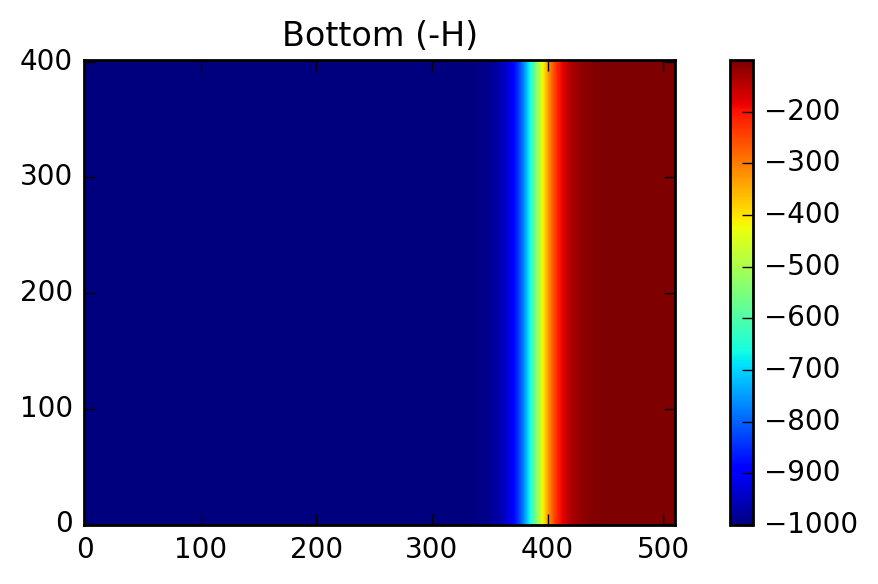

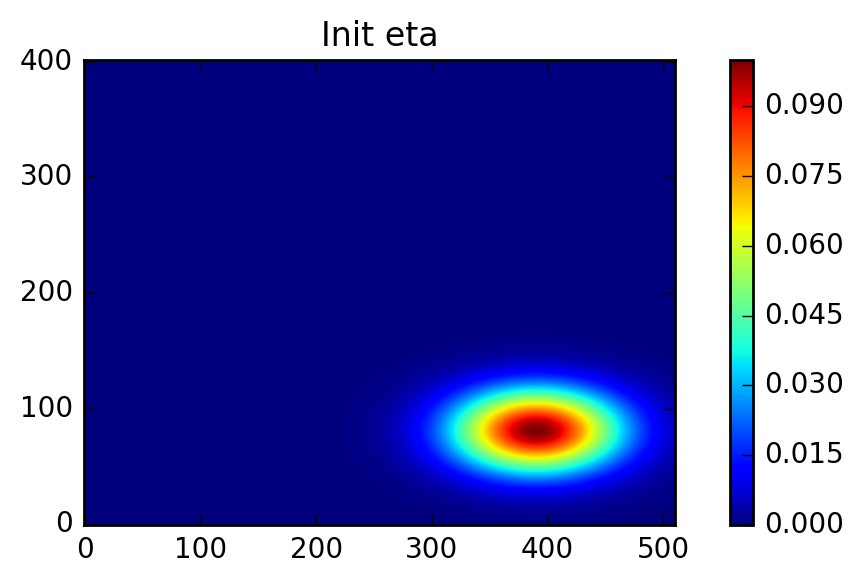

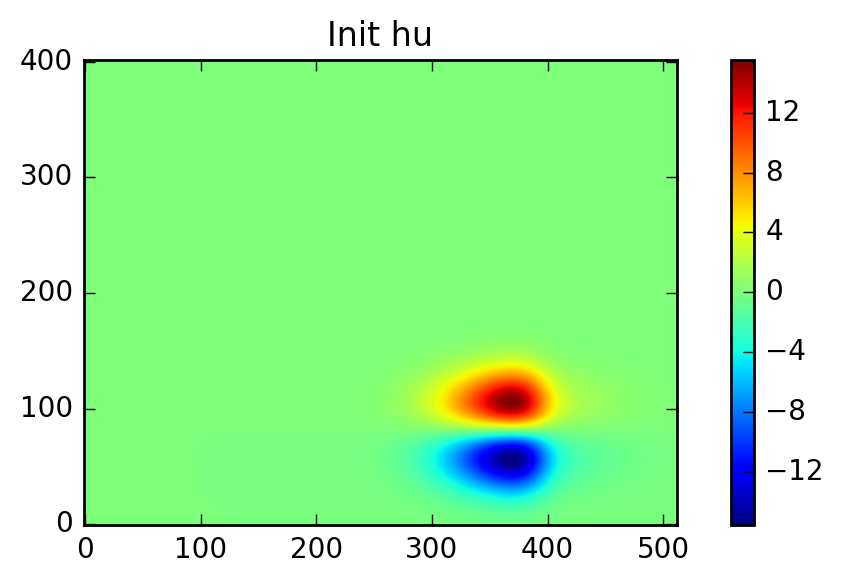

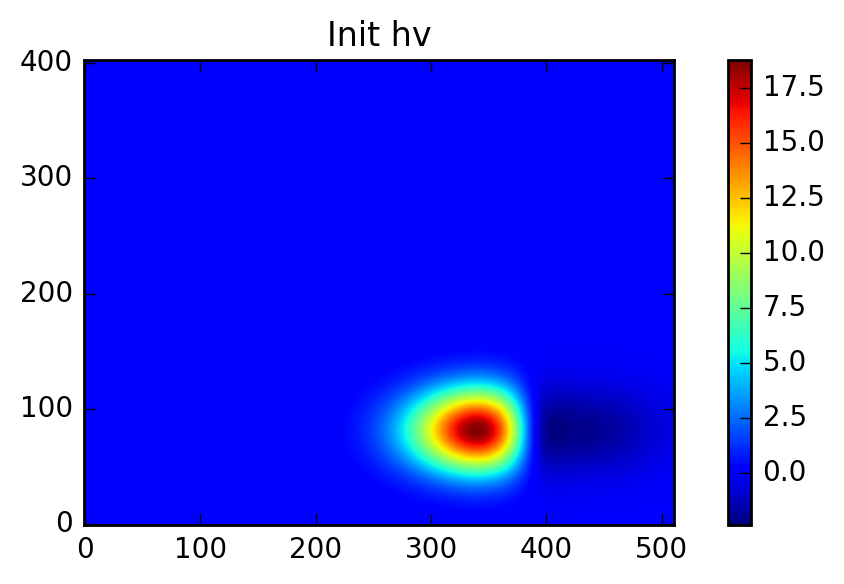

In [147]:
#Centered in time, centered in space

#Clean up old simulator if any:
if 'ctcs_sim' in globals():
    ctcs_sim.cleanUp()

ghosts = [1,1,1,1] # north, east, south, west
validDomain = [1,1,1,1] 
boundaryConditions = Common.BoundaryConditions(2,1,2,1)
if (bcSettings == 2):
    # periodic boundary conditions
    validDomain = [1, 1, 1, 10]
    boundaryConditions = Common.BoundaryConditions(2,1,2,3, spongeCells=validDomain)
    ghosts = [1, 1, 1, 10]
    print "Western boundary open"
   # print theseConditionsAreNotImplemented
    
dataShape = (ny + ghosts[0]+ghosts[2], 
             nx + ghosts[1]+ghosts[3])

h0 = np.zeros(dataShape, dtype=np.float32, order='C');
eta0 = np.zeros(dataShape, dtype=np.float32, order='C');
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32, order='C');
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32, order='C');    


# Create the bottom:
for j in range(dataShape[0]):
    y = (j+0.5-ghosts[2])*dy
    x0 = shelf_x0
    if (y > sine_center - sine_period/2 and y < sine_center + sine_period/2):
        x0 = shelf_x0 #+ sine_amplitude*np.sin((y-sine_center)*2*np.pi/(sine_period))
    for i in range(dataShape[1]):
        x = (i+0.5-ghosts[3])*dx
        h0[j,i] = deep_water_depth + (shelf_depth - deep_water_depth)*(np.tanh(tanh_lambda*(x - x0))+1)/2
        
        
bump_pos_x = (deep_water_width + shelf_drop_width/2)/total_domain_width
bump_pos_y = 0.2
addBump(eta0, nx, ny, dx, dy, bump_pos_x, bump_pos_y, 50000, ghosts)
eta0 = eta0*0.1
initializeBalancedVelocityFieldStaggered(eta0, h0, u0, v0, f, beta, g, nx, ny, dx, dy, ghosts)

fig = plt.figure(figsize=(7,3))
plt.imshow(-h0, origin='lower')
plt.colorbar()
plt.title("Bottom (-H)")

fig = plt.figure(figsize=(7,3))
plt.imshow(eta0, origin='lower')
plt.colorbar()
plt.title("Init eta")

fig = plt.figure(figsize=(7,3))
plt.imshow(u0, origin='lower')
plt.colorbar()
plt.title("Init hu")

fig = plt.figure(figsize=(7,3))
plt.imshow(v0, origin='lower')
plt.colorbar()
plt.title("Init hv")


#Initialize simulator
reload(CTCS)
T = 50
sub_t = dt*4000
writeNetCDF = True
ctcs_sim = CTCS.CTCS(cl_ctx, \
                     h0, eta0, u0, v0, \
                     nx, ny, dx, dy, dt, \
                     g, f, r, A, \
                     coriolis_beta=beta, \
                     wind_stress=wind, \
                     write_netcdf=writeNetCDF, \
                     boundary_conditions=boundaryConditions )


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, 
                                eta0[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]] , 
                                u0[validDomain[2]:-validDomain[0], validDomain[3]+1:-validDomain[1]], 
                                v0[validDomain[2]+1:-validDomain[0], validDomain[3]:-validDomain[1]])
def animate(i):
    if (i>0):
        t = ctcs_sim.step(sub_t)
    else:
        t = 0.0
    eta1, u1, v1 = ctcs_sim.download()
    
    # To increase the amplitude of the plot, increase this brighten parameter
    brighten = 1.0
    
    plotter.plot(brighten*(eta1[validDomain[2]:-validDomain[0], validDomain[3]:-validDomain[1]]), 
                 brighten*u1[validDomain[2]:-validDomain[0], validDomain[3]+1:-validDomain[1]], 
                 brighten*v1[validDomain[2]+1:-validDomain[0], validDomain[3]:-validDomain[1]])
    fig.suptitle("CTCS Time = " + "{:04.0f}".format(t) + " s", fontsize=18)

    if (i%10 == 0):
        print "{:03.0f}".format(100.0*i / T) + " % => t=" + str(t) +  "\tMax eta: " + str(np.max(eta1)) + \
        "\tMax u: " + str(np.max(u1)) + "\tMax v: " + str(np.max(v1))
        #fig.savefig(imgdir + "/{:010.0f}_ctcs.png".format(t))

anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
plt.close(anim._fig)
anim

In [148]:
if 'ctcs_sim' in globals():
    ctcs_sim.cleanUp()

Closing file netcdf_2018_01_16/CTCS_2018_01_16-15_04_10.nc ...
